# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = True
    historical = False
    create_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]error while signin
you are using nologin method, data you access may be limited



Load the datasets...
ByBitPerpetual
10000LADYSUSDT
10000NFTUSDT
10000SATSUSDT
10000STARLUSDT
10000WENUSDT
1000BONKUSDT
1000BTTUSDT
1000FLOKIUSDT
1000LUNCUSDT
1000PEPEUSDT
1000RATSUSDT
1000XECUSDT
1CATUSDT
1INCHUSDT
AAVEUSDT
ACEUSDT
ACHUSDT
ADAUSDT
AERGOUSDT
AGIUSDT
AGIXUSDT
AGLDUSDT
AIUSDT
AKROUSDT
ALGOUSDT
ALICEUSDT
ALPACAUSDT
ALPHAUSDT
ALTUSDT
AMBUSDT
ANKRUSDT
ANTUSDT
APEUSDT
API3USDT
APTUSDT
ARBUSDT
ARKMUSDT
ARKUSDT
ARPAUSDT
ARUSDT
ASTRUSDT
ATAUSDT
ATOMUSDT
AUCTIONUSDT
AUDIOUSDT
AVAXUSDT
AXLUSDT
AXSUSDT
BADGERUSDT
BAKEUSDT
BALUSDT
BANDUSDT
BATUSDT
BCHUSDT
BEAMUSDT
BELUSDT
BICOUSDT
BIGTIMEUSDT
BLURUSDT
BLZUSDT
BNBUSDT
BNTUSDT
BNXUSDT
BOBAUSDT
BONDUSDT
BSVUSDT
BSWUSDT
BTCUSDT
C98USDT
CAKEUSDT
CEEKUSDT
CELOUSDT
CELRUSDT
CETUSUSDT
CFXUSDT
CHRUSDT
CHZUSDT
CKBUSDT
COMBOUSDT
COMPUSDT
COREUSDT
COTIUSDT
CROUSDT
CRVUSDT
CTCUSDT
CTKUSDT
CTSIUSDT
CVCUSDT
CVXUSDT
CYBERUSDT
DARUSDT
DASHUSDT
DATAUSDT
DENTUSDT
DGBUSDT
DODOUSDT
DOGEUSDT
DOTUSDT
DUSKUSDT
DYDXUSDT
DYMUSDT
EDUUSDT
EGLDUSDT
ENJUSDT
ENS

100%|██████████| 1/1 [59:20<00:00, 3560.31s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9209,0.894,0.8769,0.8858,0.8906,0.893,0.9003,0.9027,0.9071,0.9212,0.9256,0.9357,0.9434,0.9487,0.9554,0.9631,0.9737,0.9887,0.9966,1.0036,1.0131,1.0183,1.0238,1.0285,-0.39,-0.77,-1.15,-1.54,-1.92,-2.3,-2.68,-3.07,-3.45,-3.83,-4.2,-4.57,-4.93,-6.97,-7.21,-7.41,-7.58,-7.71,-7.81,-7.88,-7.91,-7.95,-7.96,-7.99,41578


### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]error while signin
you are using nologin method, data you access may be limited
100%|██████████| 1/1 [16:36<00:00, 996.43s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9524,0.8963,0.8627,0.8448,0.8209,0.8065,0.7946,0.7843,0.7783,0.7692,0.7585,0.7487,0.7421,0.7416,0.7396,0.7388,0.7344,0.7325,0.7263,0.7225,0.7215,0.721,0.7189,0.7205,0.42,0.82,1.22,1.61,1.99,2.36,2.72,3.08,3.43,3.77,4.09,4.4,4.69,4.93,5.12,5.28,5.41,5.51,5.57,5.61,5.61,5.6,5.57,5.56,31584


# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2207 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

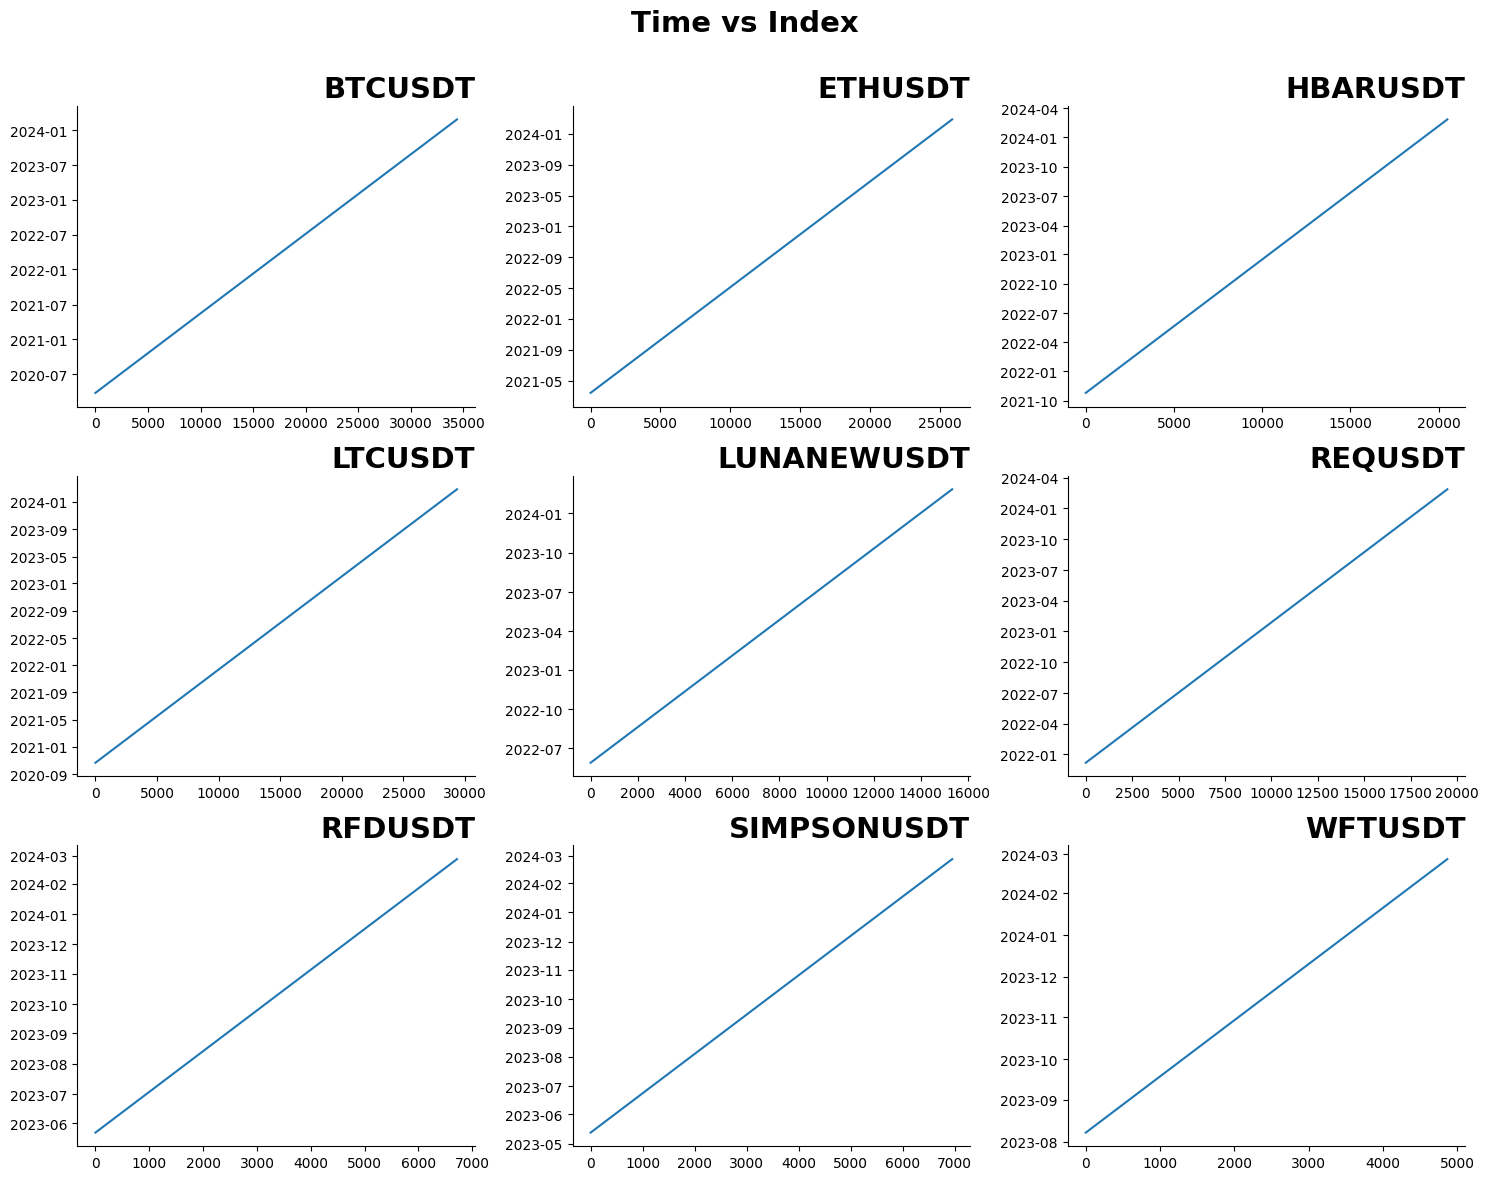

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)

# DHPUSDT 2022-02-01 23:00:00
def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    # tickers = ['ZILUSDT'] # !!!
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            # if t.year == 2024 and t.month == 2 and t.day == 15 and t.hour == 22: # !!!
            #     pass
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [1, 2, 4, 9, 14, 15, 16, 17, 18, 19, 21, 22, 23]
    sell_hours_to_save = [1, 9, 16, 17, 18, 19, 21, 23] ## 4 14, [1, 16, 17, 19, 21]
    df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

    display(train_sell.head())
    display(train_sell.shape)

error while signin
you are using nologin method, data you access may be limited


  0%|          | 0/1245 [00:00<?, ?it/s]

,time,open,high,low,close,volume,funding_rate,rsi,stoch_slowk,stoch_slowd,stoch_diff,atr,linear_reg,linear_reg_angle,macd,macdhist,macdsignal,btcd_open,btcd_high,btcd_low,btcd_close,btcd_volume,btcdom_open,btcdom_high,btcdom_low,btcdom_close,btcdom_volume,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_diff_prev_4,atr_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macdsignal_prev_4,btcdom_open_prev_4,btcdom_high_prev_4,btcdom_low_prev_4,btcdom_close_prev_4,btcdom_volume_prev_4,ticker,pattern,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,funding_rate_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_diff_prev_8,atr_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macdsignal_prev_8,btcdom_open_prev_8,btcdom_high_prev_8,btcdom_low_prev_8,btcdom_close_prev_8,btcdom_volume_prev_8,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_diff_prev_12,atr_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macdsignal_prev_12,btcdom_open_prev_12,btcdom_high_prev_12,btcdom_low_prev_12,btcdom_close_prev_12,btcdom_volume_prev_12,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,funding_rate_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_diff_prev_16,atr_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macdsignal_prev_16,btcdom_open_prev_16,btcdom_high_prev_16,btcdom_low_prev_16,btcdom_close_prev_16,btcdom_volume_prev_16,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_diff_prev_20,atr_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macdsignal_prev_20,btcdom_open_prev_20,btcdom_high_prev_20,btcdom_low_prev_20,btcdom_close_prev_20,btcdom_volume_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,funding_rate_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_diff_prev_24,atr_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macdsignal_prev_24,btcd_open_prev_24,btcd_high_prev_24,btcd_low_prev_24,btcd_close_prev_24,btcd_volume_prev_24,btcdom_open_prev_24,btcdom_high_prev_24,btcdom_low_prev_24,btcdom_close_prev_24,btcdom_volume_prev_24,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_diff_prev_28,atr_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macdsignal_prev_28,btcdom_open_prev_28,btcdom_high_prev_28,btcdom_low_prev_28,btcdom_close_prev_28,btcdom_volume_prev_28,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,funding_rate_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_diff_prev_32,atr_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macdsignal_prev_32,btcdom_open_prev_32,btcdom_high_prev_32,btcdom_low_prev_32,btcdom_close_prev_32,btcdom_volume_prev_32,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_diff_prev_36,atr_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macdsignal_prev_36,btcdom_open_prev_36,btcdom_high_prev_36,btcdom_low_prev_36,btcdom_close_prev_36,btcdom_volume_prev_36,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,funding_rate_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_diff_prev_40,atr_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macdsignal_prev_40,btcdom_open_prev_40,btcdom_high_prev_40,btcdom_low_prev_40,btcdom_close_prev_40,btcdom_volume_prev_40,high_prev_44,low_prev_44,close_prev_44,volume_prev_44,rsi_prev_44,stoch_slowk_prev_44,stoch_slowd_prev_44,stoch_diff_prev_44,atr_prev_44,linear_reg_prev_44,linear_reg_angle_prev_44,macd_prev_44,macdhist_prev_44,macdsignal_prev_44,btcdom_o

(17367, 1015)

  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

  0%|          | 0/528 [00:00<?, ?it/s]

,time,open,high,low,close,volume,funding_rate,rsi,stoch_slowk,stoch_slowd,stoch_diff,atr,linear_reg,linear_reg_angle,macd,macdhist,macdsignal,btcd_open,btcd_high,btcd_low,btcd_close,btcd_volume,btcdom_open,btcdom_high,btcdom_low,btcdom_close,btcdom_volume,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_diff_prev_4,atr_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macdsignal_prev_4,btcdom_open_prev_4,btcdom_high_prev_4,btcdom_low_prev_4,btcdom_close_prev_4,btcdom_volume_prev_4,ticker,pattern,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,funding_rate_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_diff_prev_8,atr_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macdsignal_prev_8,btcdom_open_prev_8,btcdom_high_prev_8,btcdom_low_prev_8,btcdom_close_prev_8,btcdom_volume_prev_8,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_diff_prev_12,atr_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macdsignal_prev_12,btcdom_open_prev_12,btcdom_high_prev_12,btcdom_low_prev_12,btcdom_close_prev_12,btcdom_volume_prev_12,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,funding_rate_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_diff_prev_16,atr_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macdsignal_prev_16,btcdom_open_prev_16,btcdom_high_prev_16,btcdom_low_prev_16,btcdom_close_prev_16,btcdom_volume_prev_16,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_diff_prev_20,atr_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macdsignal_prev_20,btcdom_open_prev_20,btcdom_high_prev_20,btcdom_low_prev_20,btcdom_close_prev_20,btcdom_volume_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,funding_rate_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_diff_prev_24,atr_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macdsignal_prev_24,btcd_open_prev_24,btcd_high_prev_24,btcd_low_prev_24,btcd_close_prev_24,btcd_volume_prev_24,btcdom_open_prev_24,btcdom_high_prev_24,btcdom_low_prev_24,btcdom_close_prev_24,btcdom_volume_prev_24,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_diff_prev_28,atr_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macdsignal_prev_28,btcdom_open_prev_28,btcdom_high_prev_28,btcdom_low_prev_28,btcdom_close_prev_28,btcdom_volume_prev_28,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,funding_rate_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_diff_prev_32,atr_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macdsignal_prev_32,btcdom_open_prev_32,btcdom_high_prev_32,btcdom_low_prev_32,btcdom_close_prev_32,btcdom_volume_prev_32,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_diff_prev_36,atr_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macdsignal_prev_36,btcdom_open_prev_36,btcdom_high_prev_36,btcdom_low_prev_36,btcdom_close_prev_36,btcdom_volume_prev_36,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,funding_rate_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_diff_prev_40,atr_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macdsignal_prev_40,btcdom_open_prev_40,btcdom_high_prev_40,btcdom_low_prev_40,btcdom_close_prev_40,btcdom_volume_prev_40,high_prev_44,low_prev_44,close_prev_44,volume_prev_44,rsi_prev_44,stoch_slowk_prev_44,stoch_slowd_prev_44,stoch_diff_prev_44,atr_prev_44,linear_reg_prev_44,linear_reg_angle_prev_44,macd_prev_44,macdhist_prev_44,macdsignal_prev_44,btcdom_o

(7693, 1015)

### Create train dataset

In [9]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)


# Data tests

### Test train dataframe columns

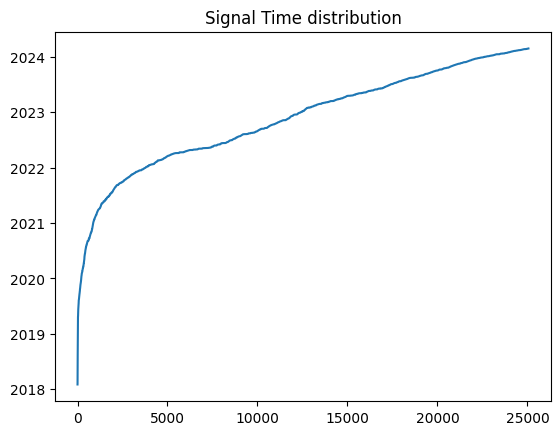

In [10]:
import re

if CFG.create_dataset:

    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)
    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + ['atr', 'pattern', 'target', 'ticker', 'ttype', 'volume'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [11]:
# if CFG.create_dataset:
prev_ticker = None
target_offset = 96

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

  0%|          | 0/17367 [00:00<?, ?it/s]

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

  0%|          | 0/7693 [00:00<?, ?it/s]

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
# display(pvt)
display(pvt[pvt['pct'] >= 0.517])
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
# display(pvt)
display(pvt[pvt['pct'] >= 0.517])
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,701,1251,0.560352,"(0.533, 0.5877)"
3,1,1,869,1608,0.540423,"(0.5162, 0.5647)"
5,2,1,816,1530,0.533333,"(0.5085, 0.5582)"
7,3,1,937,1789,0.523756,"(0.5007, 0.5468)"
11,16,1,778,1426,0.545582,"(0.5199, 0.5713)"
13,17,1,756,1448,0.522099,"(0.4965, 0.5477)"
19,21,1,796,1475,0.539661,"(0.5144, 0.565)"
21,22,1,834,1497,0.557114,"(0.5321, 0.5821)"
23,23,1,729,1270,0.574016,"(0.547, 0.6011)"


buy    17367
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    9313
0       STOCH_RSI_Volume24    8054
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.536247
0       STOCH_RSI_Volume24    0.463753
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,1,1,467,887,0.526494,"(0.4938, 0.5592)"
5,16,1,567,1073,0.528425,"(0.4987, 0.5581)"
7,17,1,504,896,0.562500,"(0.5302, 0.5948)"
9,18,1,443,837,0.529271,"(0.4956, 0.5629)"
11,19,1,466,866,0.538106,"(0.5051, 0.5711)"
13,21,1,507,932,0.543991,"(0.5122, 0.5758)"
15,23,1,515,928,0.554957,"(0.5231, 0.5868)"


sell    7693
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    4125
0       STOCH_RSI_Volume24    3568
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.536202
0       STOCH_RSI_Volume24    0.463798
dtype: float64

# Data visualization

### Visualize buy trades

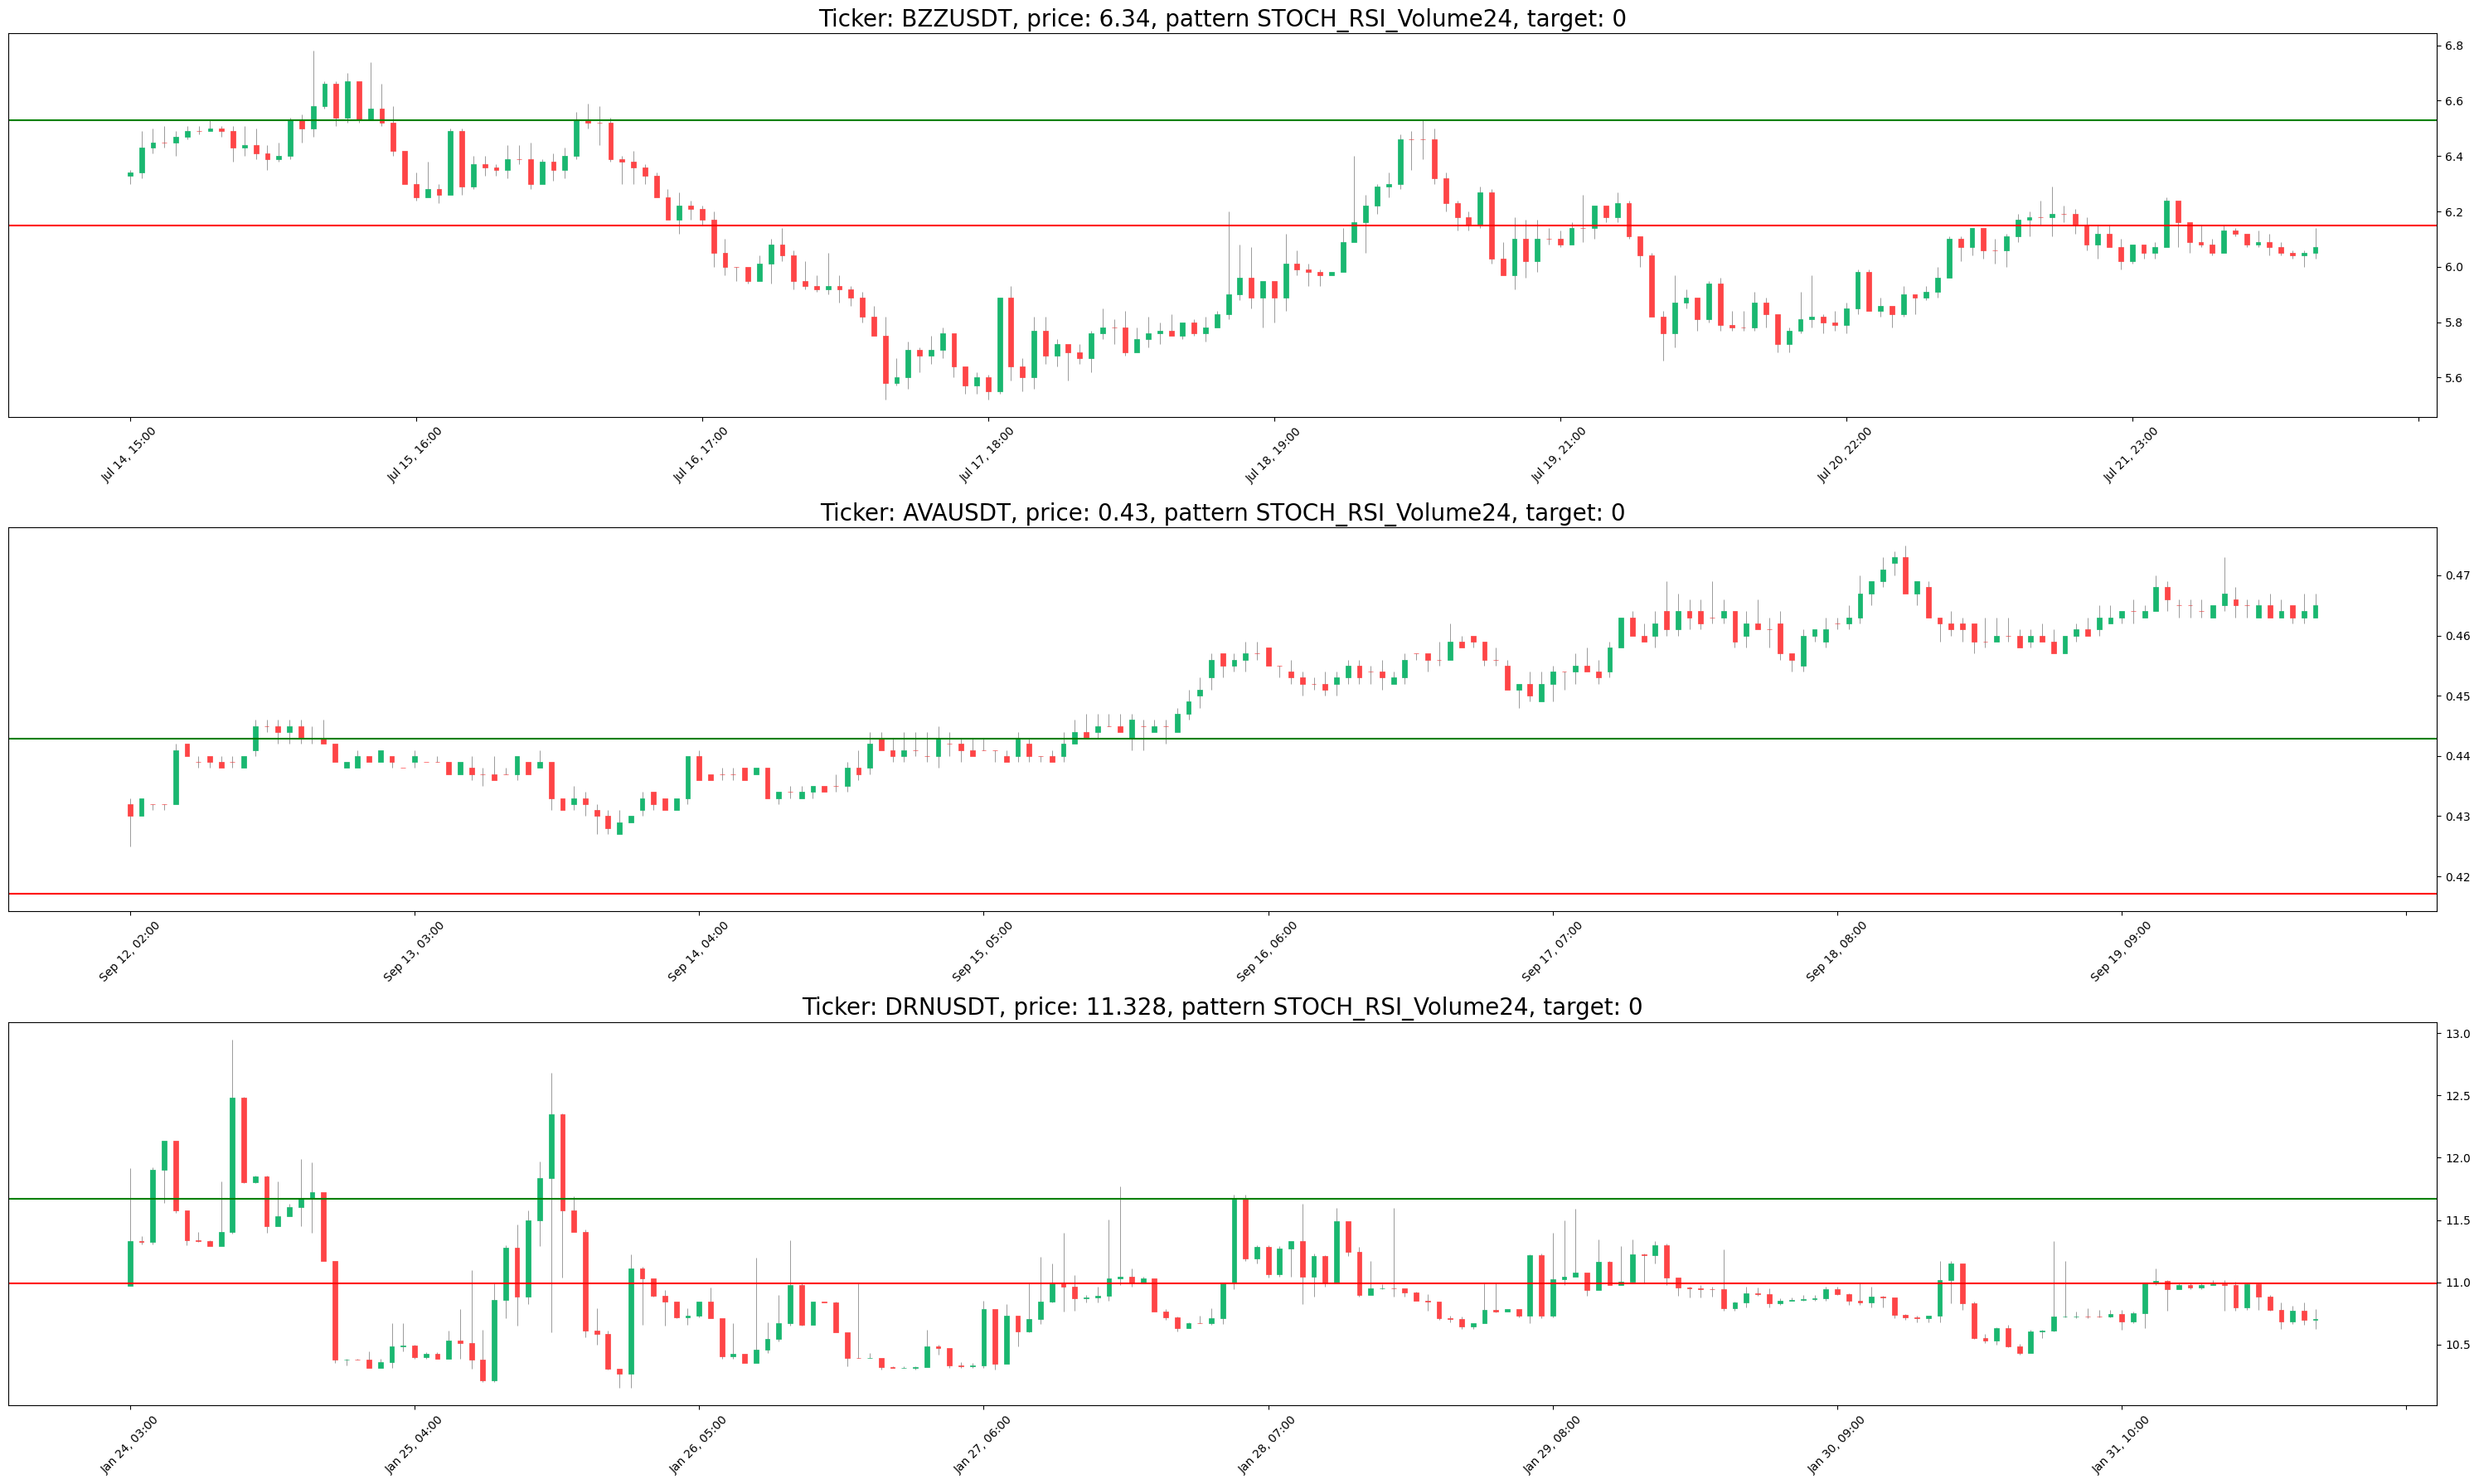

In [14]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    target_offset = 192
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

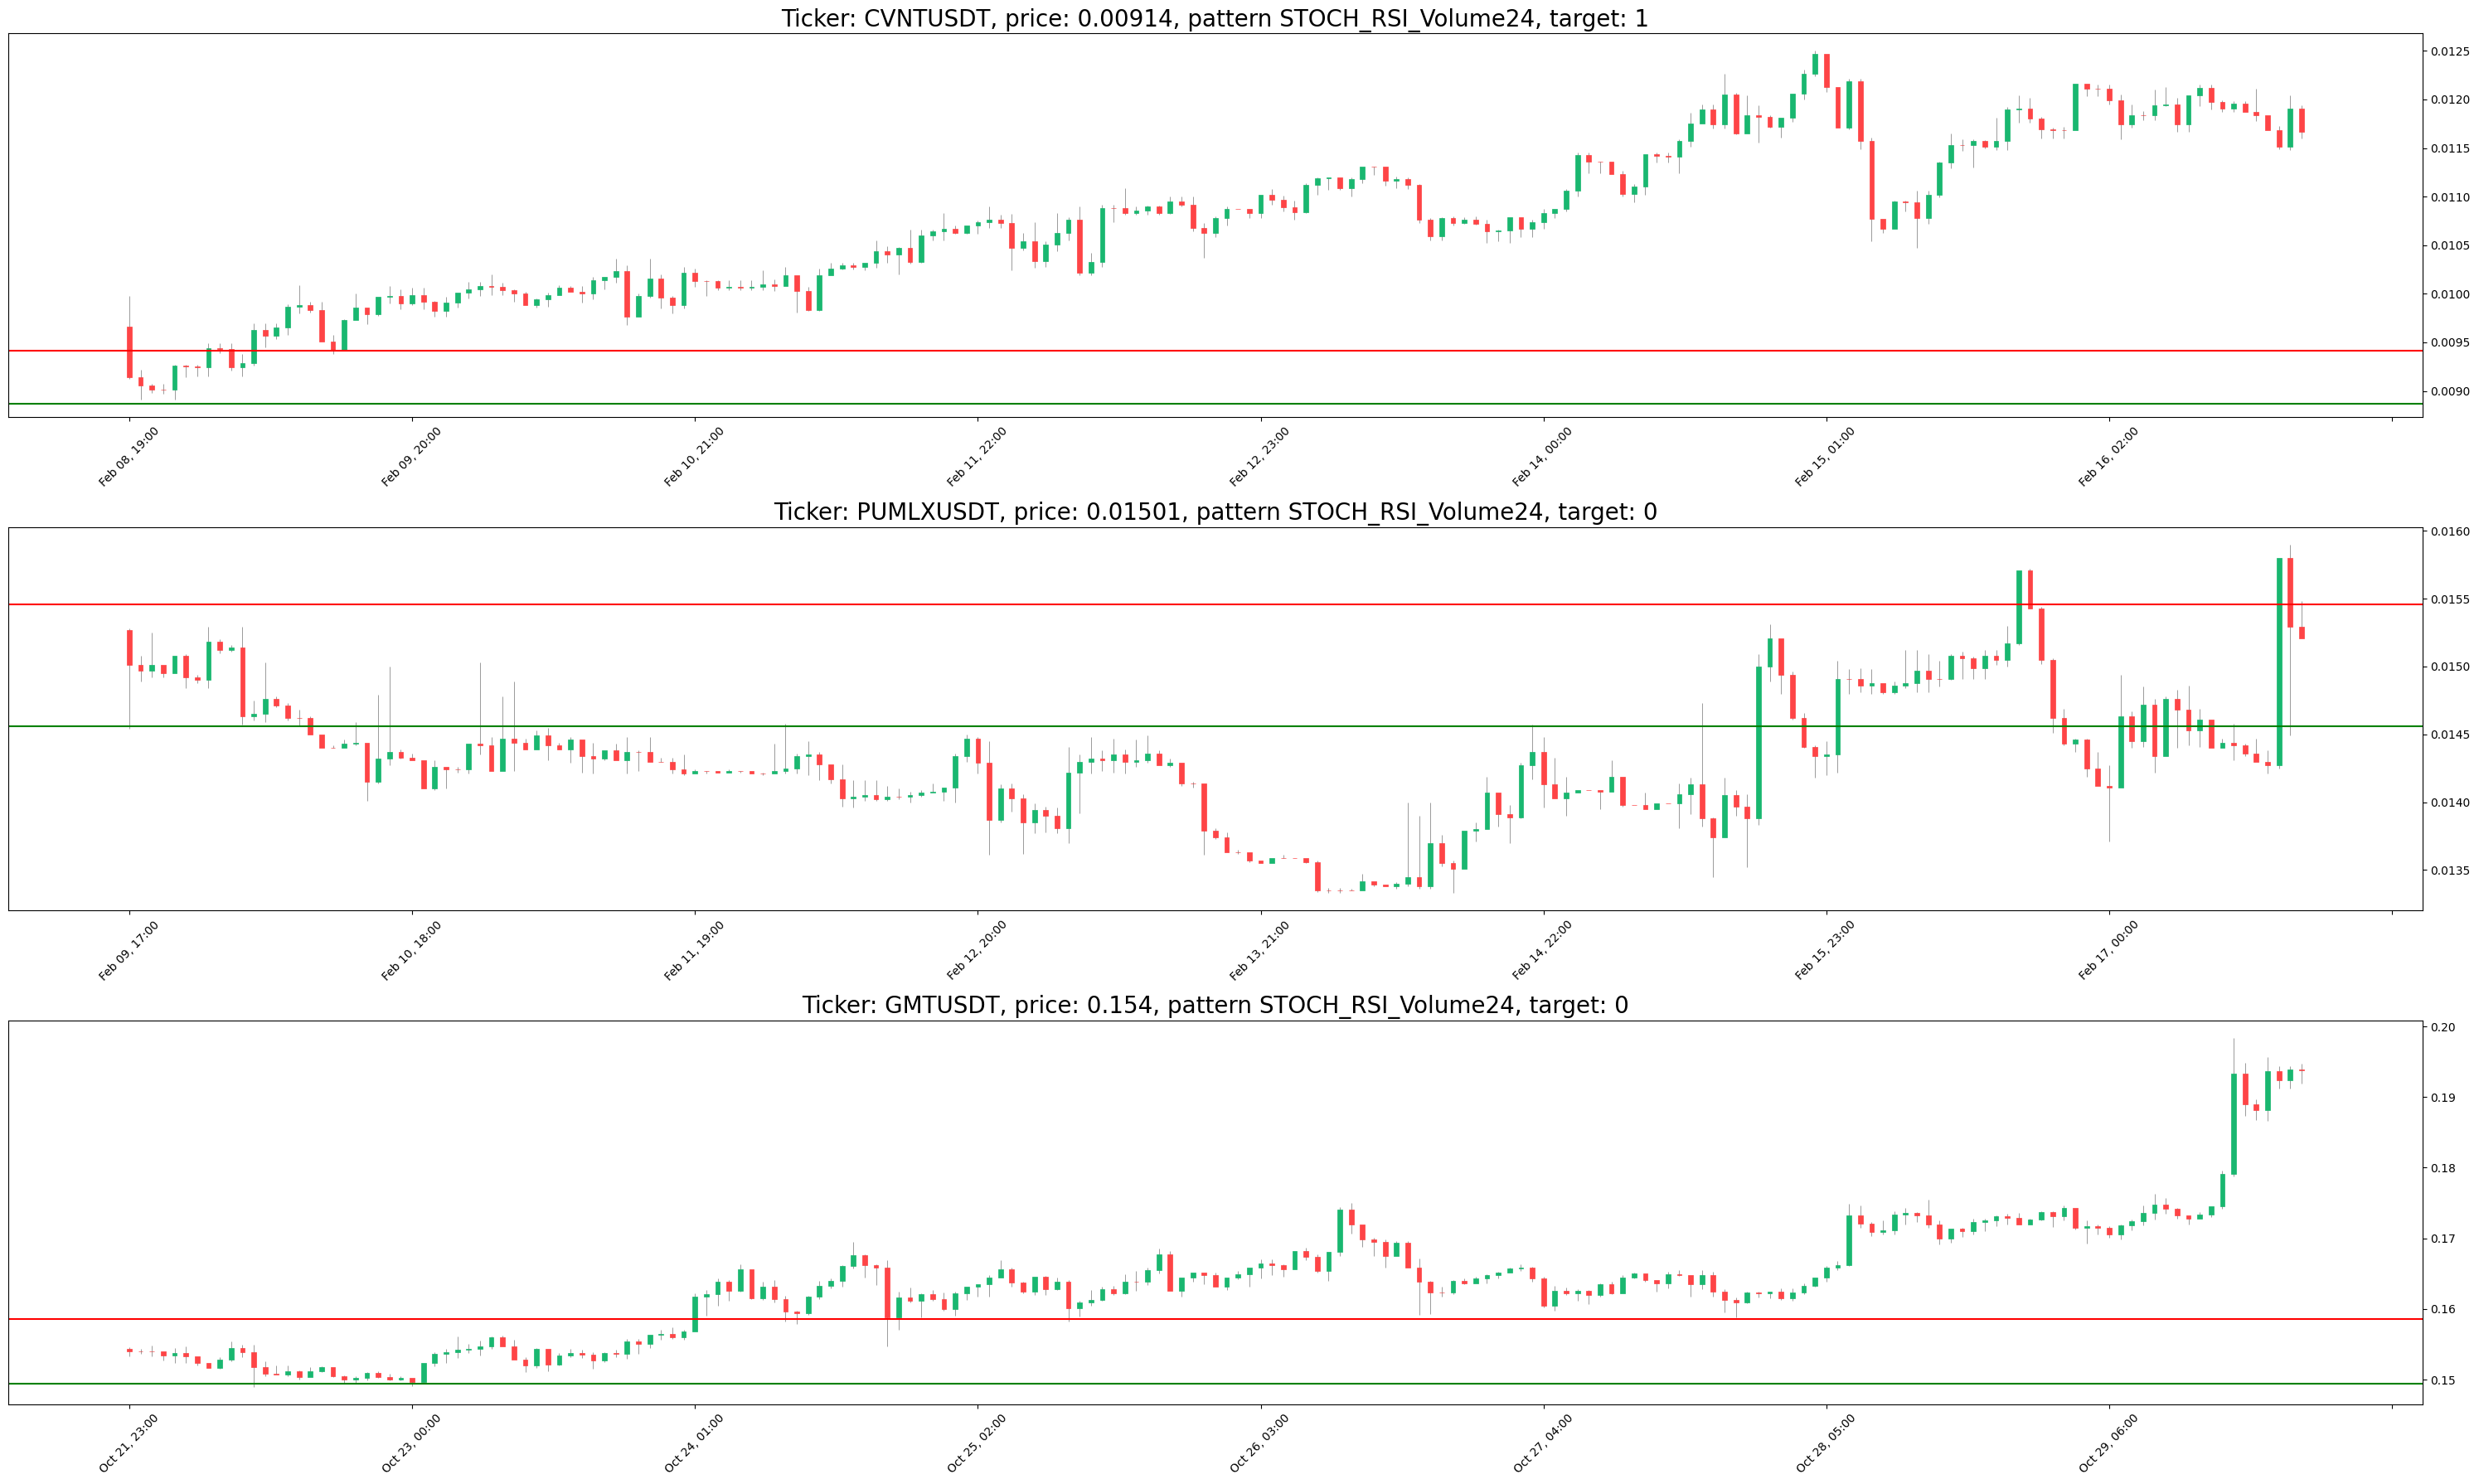

In [15]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

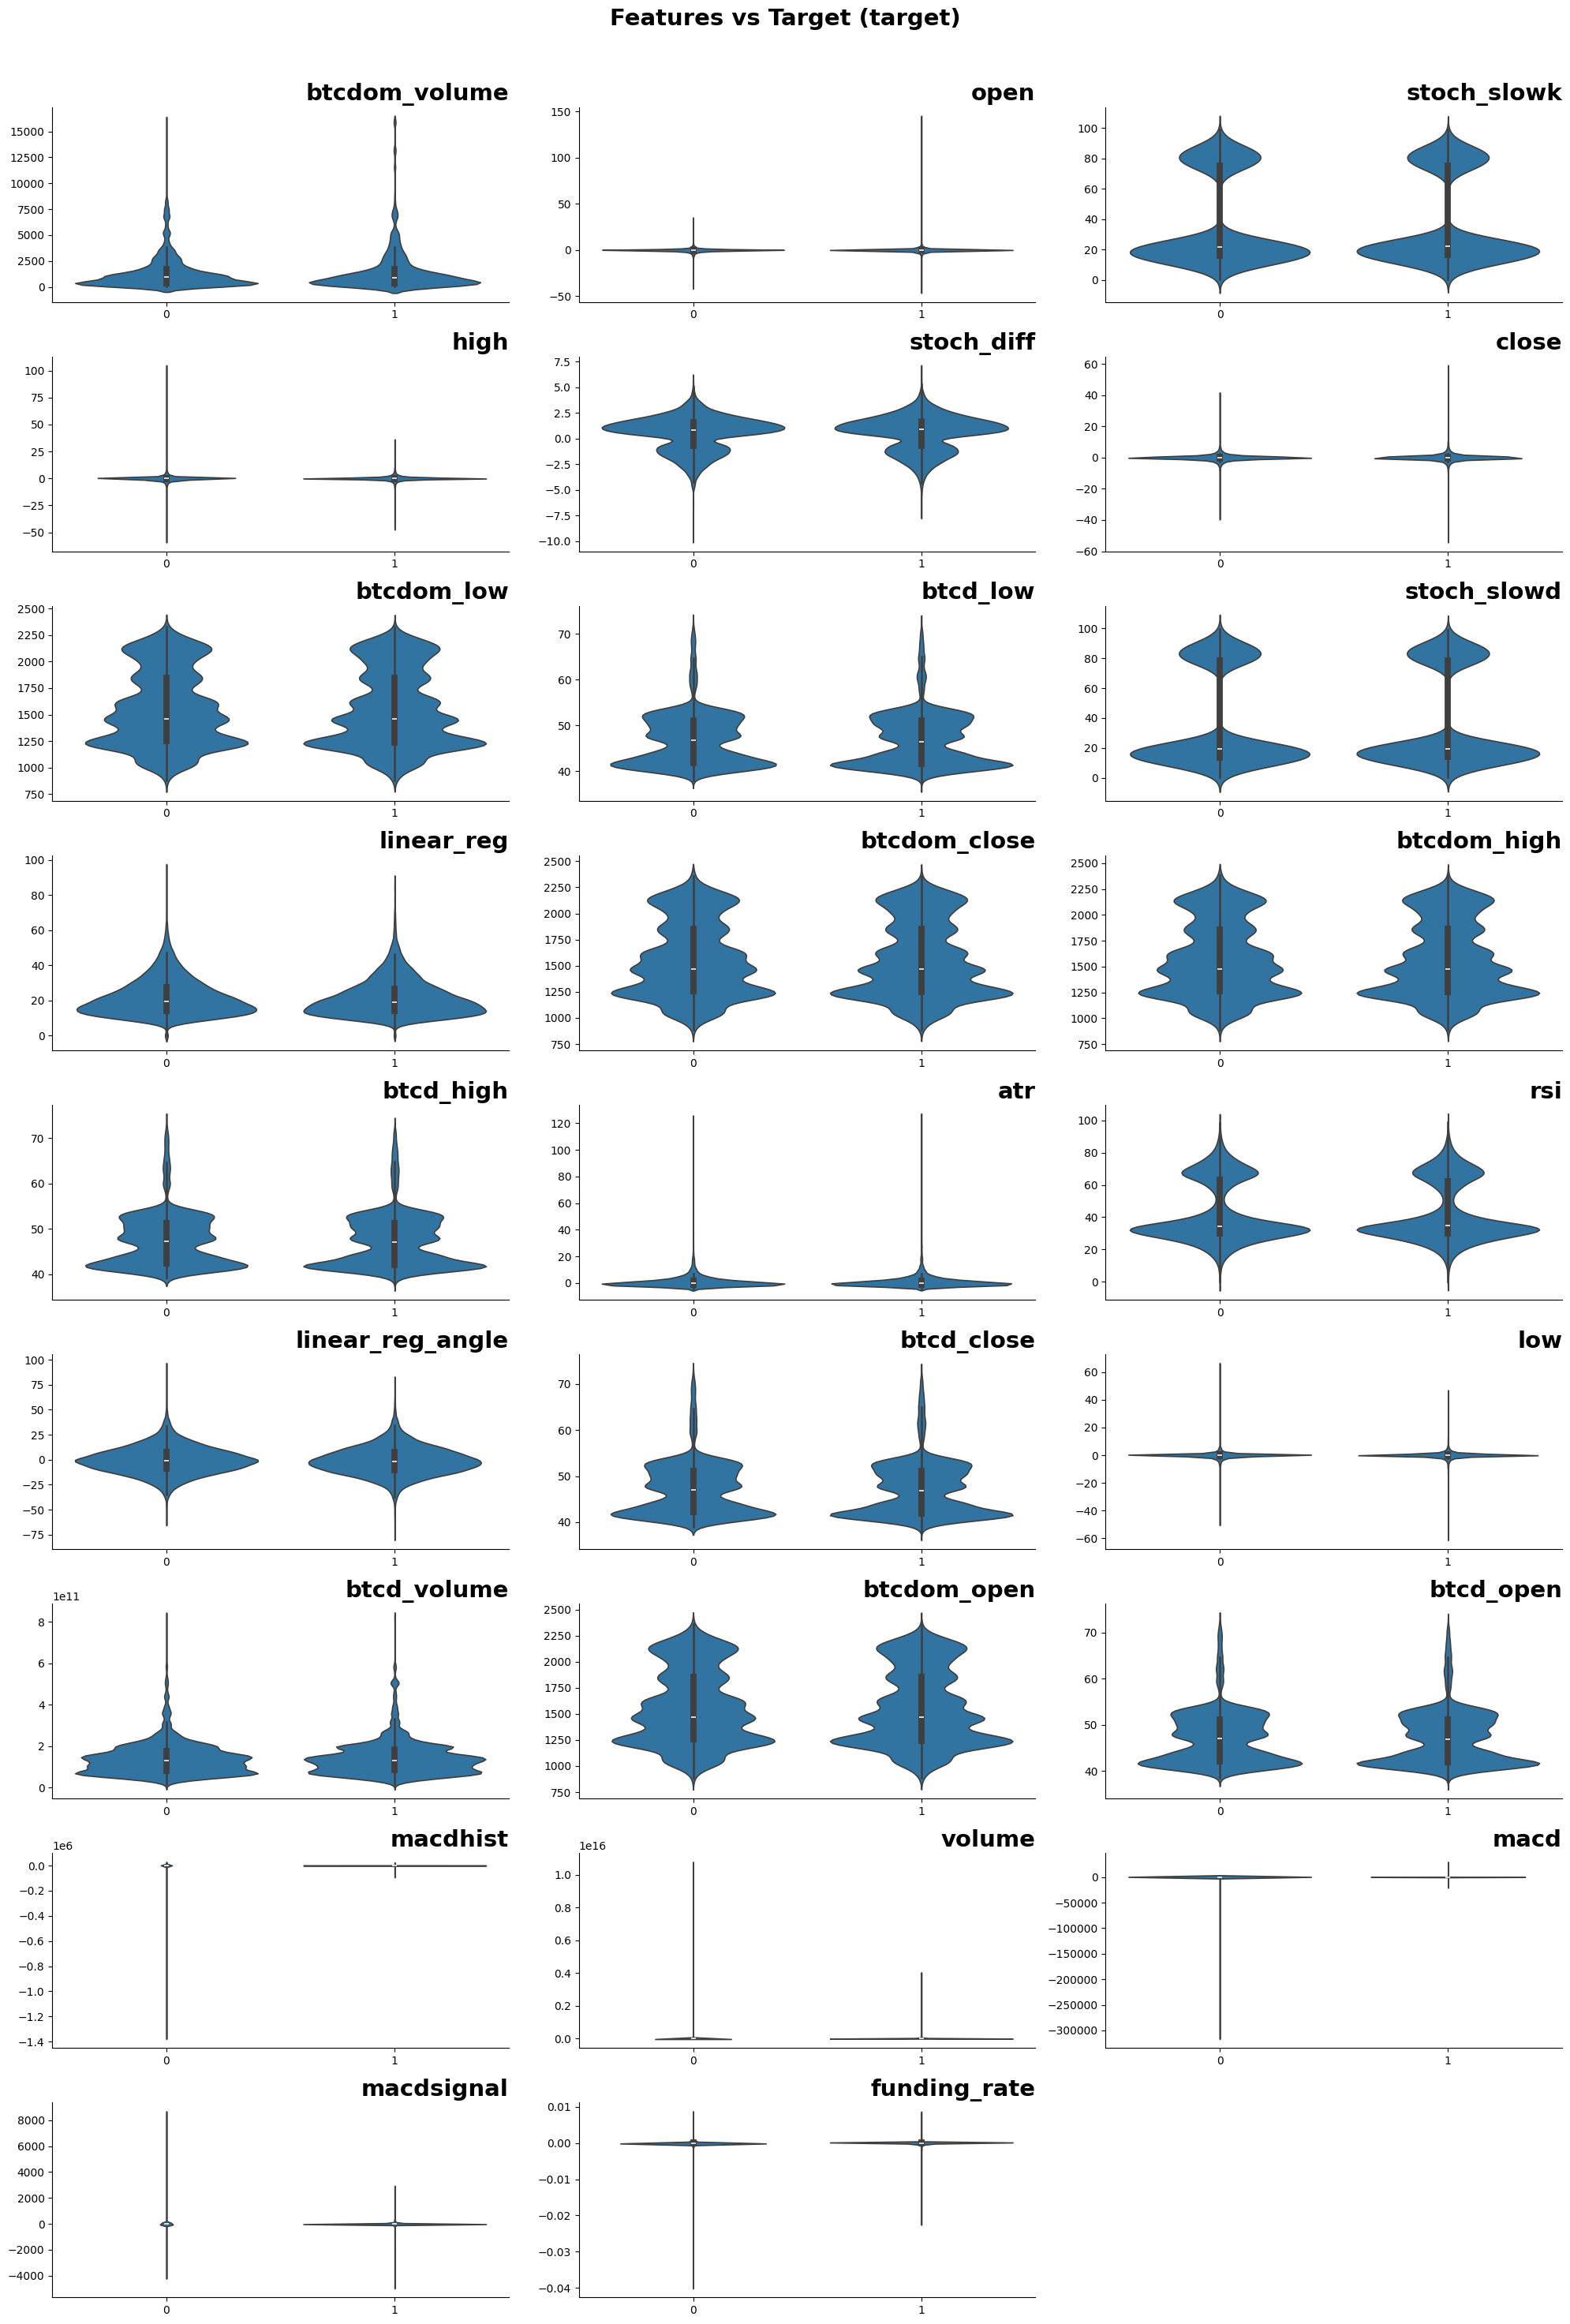

In [16]:
fi = pd.read_csv(f'feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target') 

### Show the last signals

In [17]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
# x = x[x['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(30)

,time,ticker,ttype,pattern
73132,2024-02-26 03:00:00,MNTUSDT,sell,STOCH_RSI_Volume24
73133,2024-02-26 04:00:00,SCPTUSDT,sell,STOCH_RSI_Volume24
73134,2024-02-26 04:00:00,LITTUSDT,sell,STOCH_RSI_Volume24
73135,2024-02-26 04:00:00,C98USDT,sell,STOCH_RSI_Volume24
73136,2024-02-26 04:00:00,DUELUSDT,sell,STOCH_RSI_Volume24
73137,2024-02-26 04:00:00,TLOSUSDT,sell,STOCH_RSI_Volume24
73138,2024-02-26 04:00:00,INJUSDT,sell,STOCH_RSI_Volume24
73139,2024-02-26 04:00:00,VICUSDT,sell,STOCH_RSI_Volume24
73140,2024-02-26 05:00:00,RPLUSDT,sell,STOCH_RSI_Volume24
73141,2024-02-26 05:00:00,ELFUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [18]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=400)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                  eval_metric='logloss', 
                  callbacks=[lgb.log_evaluation(100)])

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [19]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [21]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    # boruta_df_['rank'] = boruta_df_['importance'].rank()
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],])
                    # boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance.csv')
else:
    fi = pd.read_csv(f'feature_importance.csv')

### Load selected features

In [22]:
def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = [f for f in fi if f not in features_to_exclude]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv(f'feature_importance.csv')
feature_num = 430
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
features = features + ['weekday']
display(features)

['btcdom_volume',
 'open',
 'stoch_slowk',
 'high',
 'stoch_diff',
 'close',
 'btcdom_low',
 'btcd_low',
 'stoch_slowd',
 'linear_reg',
 'btcdom_close',
 'btcdom_high',
 'btcd_high',
 'atr',
 'rsi',
 'linear_reg_angle',
 'btcd_close',
 'low',
 'low_prev_4',
 'atr_prev_4',
 'linear_reg_angle_prev_4',
 'close_prev_4',
 'stoch_slowd_prev_4',
 'volume_prev_4',
 'stoch_slowk_prev_4',
 'rsi_prev_4',
 'stoch_diff_prev_4',
 'btcdom_volume_prev_4',
 'btcdom_close_prev_4',
 'linear_reg_prev_4',
 'btcdom_volume_prev_8',
 'close_prev_8',
 'volume_prev_8',
 'low_prev_8',
 'rsi_prev_8',
 'stoch_diff_prev_8',
 'close_prev_12',
 'stoch_slowd_prev_12',
 'rsi_prev_12',
 'low_prev_12',
 'btcdom_low_prev_12',
 'btcdom_high_prev_12',
 'btcdom_volume_prev_12',
 'low_prev_16',
 'btcdom_volume_prev_16',
 'stoch_slowd_prev_16',
 'btcdom_open_prev_16',
 'btcdom_high_prev_16',
 'atr_prev_16',
 'btcdom_low_prev_16',
 'macdhist_prev_16',
 'stoch_diff_prev_16',
 'high_prev_16',
 'close_prev_16',
 'btcdom_volume_pre

### Show the features that correlate with other features too much (corr >= 0.8) and are not too important

In [23]:
if CFG.select_features:
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['rank', 'feature_1'])

    features_to_exclude = list()
    corr_thresh = 0.8

    for i, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']
        corr = row['corr']

        if feature_1 in features_to_exclude:
            continue

        if corr > corr_thresh:
            features_to_exclude.append(feature_2)

    display(set(features_to_exclude))

# Train

### Functions for train and optimization

In [24]:
val_idxs = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * prec_score -  1) * prec_obj_num)}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                        
        'verbose': -1,
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'importance_type': 'gain'
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']
    
    fi = pd.read_csv(f'feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features_to_exclude = list()
    features, _ = prepare_features(fi, feature_num, features_to_exclude)
    features = features + ['weekday']
    
    oof, __, val_idxs = model_train(train_df, features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [31]:
params = {
    'boosting_type': 'goss',
    'n_estimators': 2935,
    'learning_rate': 0.000101,
    'max_depth': 10,
    'colsample_bytree': 0.86448,
    # 'subsample': 0.5394907029626385,
    'subsample_freq': 1,
    'num_leaves': 37,
    'verbosity': -1,
    'max_bin': 229,
    'reg_alpha': 0.050818,
    'reg_lambda': 2.192784e-08,
    'is_unbalance': True,
    'class_weight': 'balanced',
    'objective': 'binary',
    'importance_type': 'gain',
    'metric': 'average_precision'
    }

# params = {
#     'boosting_type': 'gbdt',
#     'n_estimators': 1126,
#     'learning_rate': 0.0035991755858287514,
#     'max_depth': 6,
#     'colsample_bytree': 0.7437349346323546,
#     'subsample': 0.5394907029626385,
#     'subsample_freq': 1,
#     'num_leaves': 237,
#     'verbosity': -1,
#     'max_bin': 117,
#     'reg_alpha': 0.0003694000166537471,
#     'reg_lambda': 9.820784723776928,
#     'is_unbalance': True,
#     'class_weight': 'balanced',
#     'objective': 'binary',
#     'importance_type': 'gain',
#     'metric': 'average_precision'
#     }

train_test = 'full' # fold, full
high_bound = 0.5
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df, features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(( 2 * oof_conf_prec_score - 1) * oof_conf_obj_num)}')
elif train_test == 'full':
    oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'lgbm.pkl')
    # save feature dictionary for further inference
    with open(f'features.json', 'w') as f:
        json.dump(feature_dict, f)

Train on full data
[100]	training's binary_logloss: 0.692141	training's average_precision: 0.716264
[200]	training's binary_logloss: 0.691141	training's average_precision: 0.719571
[300]	training's binary_logloss: 0.690162	training's average_precision: 0.7196
[400]	training's binary_logloss: 0.689193	training's average_precision: 0.719892
[500]	training's binary_logloss: 0.688239	training's average_precision: 0.720127
[600]	training's binary_logloss: 0.6873	training's average_precision: 0.720534
[700]	training's binary_logloss: 0.686372	training's average_precision: 0.721136
[800]	training's binary_logloss: 0.685456	training's average_precision: 0.721405
[900]	training's binary_logloss: 0.684554	training's average_precision: 0.721504
[1000]	training's binary_logloss: 0.683663	training's average_precision: 0.721833
[1100]	training's binary_logloss: 0.682784	training's average_precision: 0.722086
[1200]	training's binary_logloss: 0.681916	training's average_precision: 0.722167
[1300]	tra

In [32]:
# Training with 431 features
# Fold #1
# 1    0.538415
# 0    0.461585
# Name: target, dtype: float64Timestamp('2022-06-17 22:00:00')Timestamp('2024-02-22 00:00:00')
# [100]	training's binary_logloss: 0.691565	training's average_precision: 0.785881	valid_1's binary_logloss: 0.692795	valid_1's average_precision: 0.544932
# [200]	training's binary_logloss: 0.690007	training's average_precision: 0.78812	valid_1's binary_logloss: 0.692468	valid_1's average_precision: 0.54525
# [300]	training's binary_logloss: 0.688468	training's average_precision: 0.788472	valid_1's binary_logloss: 0.692169	valid_1's average_precision: 0.542821
# [400]	training's binary_logloss: 0.686938	training's average_precision: 0.790831	valid_1's binary_logloss: 0.691895	valid_1's average_precision: 0.542918
# [500]	training's binary_logloss: 0.685438	training's average_precision: 0.794092	valid_1's binary_logloss: 0.691686	valid_1's average_precision: 0.542605
# [600]	training's binary_logloss: 0.683961	training's average_precision: 0.796215	valid_1's binary_logloss: 0.691491	valid_1's average_precision: 0.542905
# [700]	training's binary_logloss: 0.682499	training's average_precision: 0.798229	valid_1's binary_logloss: 0.691362	valid_1's average_precision: 0.542568
# [800]	training's binary_logloss: 0.681048	training's average_precision: 0.799363	valid_1's binary_logloss: 0.691228	valid_1's average_precision: 0.542297
# [900]	training's binary_logloss: 0.679607	training's average_precision: 0.800281	valid_1's binary_logloss: 0.691115	valid_1's average_precision: 0.541711
# [1000]	training's binary_logloss: 0.678192	training's average_precision: 0.801452	valid_1's binary_logloss: 0.691033	valid_1's average_precision: 0.541195
# [1100]	training's binary_logloss: 0.676788	training's average_precision: 0.802485	valid_1's binary_logloss: 0.690972	valid_1's average_precision: 0.540991
# [1200]	training's binary_logloss: 0.675402	training's average_precision: 0.80318	valid_1's binary_logloss: 0.69091	valid_1's average_precision: 0.541147
# [1300]	training's binary_logloss: 0.674032	training's average_precision: 0.804002	valid_1's binary_logloss: 0.690872	valid_1's average_precision: 0.54091
# [1400]	training's binary_logloss: 0.672682	training's average_precision: 0.80457	valid_1's binary_logloss: 0.690832	valid_1's average_precision: 0.540873
# [1500]	training's binary_logloss: 0.67136	training's average_precision: 0.805052	valid_1's binary_logloss: 0.690788	valid_1's average_precision: 0.541365
# [1600]	training's binary_logloss: 0.67005	training's average_precision: 0.805794	valid_1's binary_logloss: 0.690768	valid_1's average_precision: 0.54147
# [1700]	training's binary_logloss: 0.66875	training's average_precision: 0.806318	valid_1's binary_logloss: 0.690769	valid_1's average_precision: 0.541447
# [1800]	training's binary_logloss: 0.667462	training's average_precision: 0.806712	valid_1's binary_logloss: 0.690784	valid_1's average_precision: 0.541221
# [1900]	training's binary_logloss: 0.666192	training's average_precision: 0.807202	valid_1's binary_logloss: 0.690805	valid_1's average_precision: 0.540873
# [2000]	training's binary_logloss: 0.664939	training's average_precision: 0.807621	valid_1's binary_logloss: 0.690847	valid_1's average_precision: 0.540013
# [2100]	training's binary_logloss: 0.663696	training's average_precision: 0.808099	valid_1's binary_logloss: 0.690895	valid_1's average_precision: 0.539547
# [2200]	training's binary_logloss: 0.662475	training's average_precision: 0.80863	valid_1's binary_logloss: 0.69096	valid_1's average_precision: 0.539264
# [2300]	training's binary_logloss: 0.661268	training's average_precision: 0.809068	valid_1's binary_logloss: 0.691017	valid_1's average_precision: 0.53921
# [2400]	training's binary_logloss: 0.660065	training's average_precision: 0.809446	valid_1's binary_logloss: 0.691088	valid_1's average_precision: 0.539288
# [2500]	training's binary_logloss: 0.658888	training's average_precision: 0.81007	valid_1's binary_logloss: 0.691176	valid_1's average_precision: 0.538901
# [2600]	training's binary_logloss: 0.657714	training's average_precision: 0.810516	valid_1's binary_logloss: 0.691254	valid_1's average_precision: 0.539019
# [2700]	training's binary_logloss: 0.656563	training's average_precision: 0.811069	valid_1's binary_logloss: 0.691335	valid_1's average_precision: 0.53883
# [2800]	training's binary_logloss: 0.655419	training's average_precision: 0.811609	valid_1's binary_logloss: 0.691427	valid_1's average_precision: 0.53884
# [2900]	training's binary_logloss: 0.65429	training's average_precision: 0.812174	valid_1's binary_logloss: 0.691522	valid_1's average_precision: 0.53853
# Logloss: 0.6915582592372952, Confident objects precision: 0.5467914438502673
# Number of confident objects 5984, % of confident objects: 0.7286009984171435
# Number of profitable objects: 560
# Fold #2
# 1    0.545035
# 0    0.454965
# Name: target, dtype: float64Timestamp('2022-11-17 17:00:00')Timestamp('2024-02-22 00:00:00')
# [100]	training's binary_logloss: 0.69174	training's average_precision: 0.758644	valid_1's binary_logloss: 0.692987	valid_1's average_precision: 0.607128
# [200]	training's binary_logloss: 0.690359	training's average_precision: 0.762271	valid_1's binary_logloss: 0.692853	valid_1's average_precision: 0.605946
# [300]	training's binary_logloss: 0.688991	training's average_precision: 0.761353	valid_1's binary_logloss: 0.692735	valid_1's average_precision: 0.605124
# [400]	training's binary_logloss: 0.687641	training's average_precision: 0.761757	valid_1's binary_logloss: 0.692594	valid_1's average_precision: 0.606016
# [500]	training's binary_logloss: 0.686311	training's average_precision: 0.762008	valid_1's binary_logloss: 0.692487	valid_1's average_precision: 0.605842
# [600]	training's binary_logloss: 0.685001	training's average_precision: 0.762314	valid_1's binary_logloss: 0.692396	valid_1's average_precision: 0.605797
# [700]	training's binary_logloss: 0.683712	training's average_precision: 0.763521	valid_1's binary_logloss: 0.69227	valid_1's average_precision: 0.606285
# [800]	training's binary_logloss: 0.682437	training's average_precision: 0.764186	valid_1's binary_logloss: 0.69219	valid_1's average_precision: 0.60619
# [900]	training's binary_logloss: 0.681182	training's average_precision: 0.764507	valid_1's binary_logloss: 0.692115	valid_1's average_precision: 0.605984
# [1000]	training's binary_logloss: 0.679942	training's average_precision: 0.764706	valid_1's binary_logloss: 0.692034	valid_1's average_precision: 0.605741
# [1100]	training's binary_logloss: 0.678719	training's average_precision: 0.765168	valid_1's binary_logloss: 0.691976	valid_1's average_precision: 0.605661
# [1200]	training's binary_logloss: 0.67751	training's average_precision: 0.765526	valid_1's binary_logloss: 0.691909	valid_1's average_precision: 0.605517
# [1300]	training's binary_logloss: 0.676316	training's average_precision: 0.766021	valid_1's binary_logloss: 0.691911	valid_1's average_precision: 0.605231
# [1400]	training's binary_logloss: 0.675143	training's average_precision: 0.766505	valid_1's binary_logloss: 0.691915	valid_1's average_precision: 0.605044
# [1500]	training's binary_logloss: 0.673984	training's average_precision: 0.76703	valid_1's binary_logloss: 0.69193	valid_1's average_precision: 0.604236
# [1600]	training's binary_logloss: 0.672835	training's average_precision: 0.767924	valid_1's binary_logloss: 0.691877	valid_1's average_precision: 0.606038
# [1700]	training's binary_logloss: 0.6717	training's average_precision: 0.768758	valid_1's binary_logloss: 0.691799	valid_1's average_precision: 0.606625
# [1800]	training's binary_logloss: 0.670577	training's average_precision: 0.769791	valid_1's binary_logloss: 0.691707	valid_1's average_precision: 0.607109
# [1900]	training's binary_logloss: 0.669463	training's average_precision: 0.770653	valid_1's binary_logloss: 0.691624	valid_1's average_precision: 0.607276
# [2000]	training's binary_logloss: 0.668366	training's average_precision: 0.771399	valid_1's binary_logloss: 0.691526	valid_1's average_precision: 0.607487
# [2100]	training's binary_logloss: 0.667279	training's average_precision: 0.77211	valid_1's binary_logloss: 0.691444	valid_1's average_precision: 0.60745
# [2200]	training's binary_logloss: 0.666208	training's average_precision: 0.772717	valid_1's binary_logloss: 0.69135	valid_1's average_precision: 0.607161
# [2300]	training's binary_logloss: 0.665144	training's average_precision: 0.773393	valid_1's binary_logloss: 0.691244	valid_1's average_precision: 0.606698
# [2400]	training's binary_logloss: 0.664097	training's average_precision: 0.774177	valid_1's binary_logloss: 0.691161	valid_1's average_precision: 0.606339
# [2500]	training's binary_logloss: 0.663066	training's average_precision: 0.774828	valid_1's binary_logloss: 0.691087	valid_1's average_precision: 0.606154
# [2600]	training's binary_logloss: 0.662045	training's average_precision: 0.775494	valid_1's binary_logloss: 0.69101	valid_1's average_precision: 0.605922
# [2700]	training's binary_logloss: 0.661037	training's average_precision: 0.77618	valid_1's binary_logloss: 0.69093	valid_1's average_precision: 0.605708
# [2800]	training's binary_logloss: 0.66004	training's average_precision: 0.776761	valid_1's binary_logloss: 0.69082	valid_1's average_precision: 0.605752
# [2900]	training's binary_logloss: 0.659053	training's average_precision: 0.777348	valid_1's binary_logloss: 0.69073	valid_1's average_precision: 0.605482
# Logloss: 0.6906931430072585, Confident objects precision: 0.6310122038765255
# Number of confident objects 1393, % of confident objects: 0.2073842489206491
# Number of profitable objects: 365
# Fold #3
# 1    0.547182
# 0    0.452818
# Name: target, dtype: float64Timestamp('2023-04-18 16:00:00')Timestamp('2024-02-22 00:00:00')
# [100]	training's binary_logloss: 0.691784	training's average_precision: 0.746226	valid_1's binary_logloss: 0.693251	valid_1's average_precision: 0.531562
# [200]	training's binary_logloss: 0.690441	training's average_precision: 0.75119	valid_1's binary_logloss: 0.693344	valid_1's average_precision: 0.527699
# [300]	training's binary_logloss: 0.689117	training's average_precision: 0.749475	valid_1's binary_logloss: 0.693456	valid_1's average_precision: 0.530515
# [400]	training's binary_logloss: 0.687814	training's average_precision: 0.749691	valid_1's binary_logloss: 0.693582	valid_1's average_precision: 0.529591
# [500]	training's binary_logloss: 0.686529	training's average_precision: 0.749743	valid_1's binary_logloss: 0.693682	valid_1's average_precision: 0.529414
# [600]	training's binary_logloss: 0.685263	training's average_precision: 0.750269	valid_1's binary_logloss: 0.69377	valid_1's average_precision: 0.531304
# [700]	training's binary_logloss: 0.684016	training's average_precision: 0.751092	valid_1's binary_logloss: 0.693853	valid_1's average_precision: 0.530702
# [800]	training's binary_logloss: 0.682788	training's average_precision: 0.75166	valid_1's binary_logloss: 0.693936	valid_1's average_precision: 0.531066
# [900]	training's binary_logloss: 0.681576	training's average_precision: 0.752373	valid_1's binary_logloss: 0.694044	valid_1's average_precision: 0.531107
# [1000]	training's binary_logloss: 0.680375	training's average_precision: 0.75334	valid_1's binary_logloss: 0.694155	valid_1's average_precision: 0.531218
# [1100]	training's binary_logloss: 0.679188	training's average_precision: 0.754218	valid_1's binary_logloss: 0.694267	valid_1's average_precision: 0.531501
# [1200]	training's binary_logloss: 0.678017	training's average_precision: 0.754812	valid_1's binary_logloss: 0.694383	valid_1's average_precision: 0.532357
# [1300]	training's binary_logloss: 0.676865	training's average_precision: 0.755568	valid_1's binary_logloss: 0.694499	valid_1's average_precision: 0.532706
# [1400]	training's binary_logloss: 0.675733	training's average_precision: 0.756086	valid_1's binary_logloss: 0.6946	valid_1's average_precision: 0.534076
# [1500]	training's binary_logloss: 0.674614	training's average_precision: 0.756498	valid_1's binary_logloss: 0.694682	valid_1's average_precision: 0.536495
# [1600]	training's binary_logloss: 0.673508	training's average_precision: 0.756775	valid_1's binary_logloss: 0.694763	valid_1's average_precision: 0.538362
# [1700]	training's binary_logloss: 0.672417	training's average_precision: 0.757128	valid_1's binary_logloss: 0.694787	valid_1's average_precision: 0.541473
# [1800]	training's binary_logloss: 0.671335	training's average_precision: 0.75749	valid_1's binary_logloss: 0.694835	valid_1's average_precision: 0.54401
# [1900]	training's binary_logloss: 0.670267	training's average_precision: 0.757944	valid_1's binary_logloss: 0.69486	valid_1's average_precision: 0.546326
# [2000]	training's binary_logloss: 0.669218	training's average_precision: 0.758331	valid_1's binary_logloss: 0.69488	valid_1's average_precision: 0.548561
# [2100]	training's binary_logloss: 0.668177	training's average_precision: 0.758741	valid_1's binary_logloss: 0.694911	valid_1's average_precision: 0.549453
# [2200]	training's binary_logloss: 0.66715	training's average_precision: 0.759222	valid_1's binary_logloss: 0.694964	valid_1's average_precision: 0.550582
# [2300]	training's binary_logloss: 0.666138	training's average_precision: 0.759499	valid_1's binary_logloss: 0.695028	valid_1's average_precision: 0.551351
# [2400]	training's binary_logloss: 0.665135	training's average_precision: 0.759858	valid_1's binary_logloss: 0.695114	valid_1's average_precision: 0.551962
# [2500]	training's binary_logloss: 0.664154	training's average_precision: 0.760178	valid_1's binary_logloss: 0.695164	valid_1's average_precision: 0.5526
# [2600]	training's binary_logloss: 0.663179	training's average_precision: 0.760523	valid_1's binary_logloss: 0.695191	valid_1's average_precision: 0.553405
# [2700]	training's binary_logloss: 0.662216	training's average_precision: 0.760872	valid_1's binary_logloss: 0.695249	valid_1's average_precision: 0.554189
# [2800]	training's binary_logloss: 0.661277	training's average_precision: 0.761096	valid_1's binary_logloss: 0.695287	valid_1's average_precision: 0.555356
# [2900]	training's binary_logloss: 0.660338	training's average_precision: 0.761433	valid_1's binary_logloss: 0.695358	valid_1's average_precision: 0.555988
# Logloss: 0.6953931121684221, Confident objects precision: 0.5686274509803921
# Number of confident objects 408, % of confident objects: 0.08517745302713987
# Number of profitable objects: 56
# Fold #4
# 1    0.567154
# 0    0.432846
# Name: target, dtype: float64Timestamp('2023-08-08 17:00:00')Timestamp('2024-02-22 00:00:00')
# [100]	training's binary_logloss: 0.691899	training's average_precision: 0.737588	valid_1's binary_logloss: 0.692935	valid_1's average_precision: 0.636916
# [200]	training's binary_logloss: 0.690662	training's average_precision: 0.740427	valid_1's binary_logloss: 0.692728	valid_1's average_precision: 0.637791
# [300]	training's binary_logloss: 0.689456	training's average_precision: 0.738539	valid_1's binary_logloss: 0.692522	valid_1's average_precision: 0.637173
# [400]	training's binary_logloss: 0.688271	training's average_precision: 0.738225	valid_1's binary_logloss: 0.692323	valid_1's average_precision: 0.635419
# [500]	training's binary_logloss: 0.687093	training's average_precision: 0.739101	valid_1's binary_logloss: 0.69219	valid_1's average_precision: 0.63527
# [600]	training's binary_logloss: 0.685939	training's average_precision: 0.739562	valid_1's binary_logloss: 0.692043	valid_1's average_precision: 0.635687
# [700]	training's binary_logloss: 0.684794	training's average_precision: 0.740533	valid_1's binary_logloss: 0.691901	valid_1's average_precision: 0.636152
# [800]	training's binary_logloss: 0.683668	training's average_precision: 0.741313	valid_1's binary_logloss: 0.691742	valid_1's average_precision: 0.635948
# [900]	training's binary_logloss: 0.682555	training's average_precision: 0.741802	valid_1's binary_logloss: 0.691604	valid_1's average_precision: 0.636796
# [1000]	training's binary_logloss: 0.681458	training's average_precision: 0.742287	valid_1's binary_logloss: 0.691464	valid_1's average_precision: 0.637452
# [1100]	training's binary_logloss: 0.68037	training's average_precision: 0.743097	valid_1's binary_logloss: 0.6913	valid_1's average_precision: 0.637324
# [1200]	training's binary_logloss: 0.679304	training's average_precision: 0.743444	valid_1's binary_logloss: 0.691165	valid_1's average_precision: 0.637386
# [1300]	training's binary_logloss: 0.678249	training's average_precision: 0.743927	valid_1's binary_logloss: 0.691038	valid_1's average_precision: 0.636594
# [1400]	training's binary_logloss: 0.67721	training's average_precision: 0.744409	valid_1's binary_logloss: 0.690901	valid_1's average_precision: 0.637312
# [1500]	training's binary_logloss: 0.676185	training's average_precision: 0.744547	valid_1's binary_logloss: 0.69076	valid_1's average_precision: 0.637466
# [1600]	training's binary_logloss: 0.675178	training's average_precision: 0.744704	valid_1's binary_logloss: 0.690598	valid_1's average_precision: 0.638531
# [1700]	training's binary_logloss: 0.674175	training's average_precision: 0.745146	valid_1's binary_logloss: 0.690456	valid_1's average_precision: 0.641248
# [1800]	training's binary_logloss: 0.673191	training's average_precision: 0.745444	valid_1's binary_logloss: 0.690279	valid_1's average_precision: 0.644672
# [1900]	training's binary_logloss: 0.672215	training's average_precision: 0.745909	valid_1's binary_logloss: 0.690103	valid_1's average_precision: 0.647779
# [2000]	training's binary_logloss: 0.671255	training's average_precision: 0.746262	valid_1's binary_logloss: 0.689938	valid_1's average_precision: 0.650072
# [2100]	training's binary_logloss: 0.670307	training's average_precision: 0.74678	valid_1's binary_logloss: 0.689779	valid_1's average_precision: 0.651658
# [2200]	training's binary_logloss: 0.669365	training's average_precision: 0.747351	valid_1's binary_logloss: 0.689666	valid_1's average_precision: 0.651855
# [2300]	training's binary_logloss: 0.668432	training's average_precision: 0.747956	valid_1's binary_logloss: 0.68955	valid_1's average_precision: 0.652214
# [2400]	training's binary_logloss: 0.667512	training's average_precision: 0.74847	valid_1's binary_logloss: 0.689444	valid_1's average_precision: 0.65237
# [2500]	training's binary_logloss: 0.666606	training's average_precision: 0.748765	valid_1's binary_logloss: 0.689344	valid_1's average_precision: 0.653266
# [2600]	training's binary_logloss: 0.665711	training's average_precision: 0.749154	valid_1's binary_logloss: 0.689265	valid_1's average_precision: 0.653362
# [2700]	training's binary_logloss: 0.664824	training's average_precision: 0.749576	valid_1's binary_logloss: 0.689175	valid_1's average_precision: 0.653505
# [2800]	training's binary_logloss: 0.663949	training's average_precision: 0.749908	valid_1's binary_logloss: 0.689116	valid_1's average_precision: 0.653139
# [2900]	training's binary_logloss: 0.663083	training's average_precision: 0.75053	valid_1's binary_logloss: 0.689088	valid_1's average_precision: 0.652744
# Logloss: 0.689068578715713, Confident objects precision: 0.6724137931034483
# Number of confident objects 754, % of confident objects: 0.24520325203252033
# Number of profitable objects: 260
# Fold #5
# 1    0.545129
# 0    0.454871
# Name: target, dtype: float64Timestamp('2023-12-01 18:00:00')Timestamp('2024-02-22 00:00:00')
# [100]	training's binary_logloss: 0.692055	training's average_precision: 0.727043	valid_1's binary_logloss: 0.692834	valid_1's average_precision: 0.633165
# [200]	training's binary_logloss: 0.690978	training's average_precision: 0.728641	valid_1's binary_logloss: 0.692499	valid_1's average_precision: 0.63313
# [300]	training's binary_logloss: 0.68991	training's average_precision: 0.728889	valid_1's binary_logloss: 0.692173	valid_1's average_precision: 0.628614
# [400]	training's binary_logloss: 0.68886	training's average_precision: 0.72995	valid_1's binary_logloss: 0.691844	valid_1's average_precision: 0.634771
# [500]	training's binary_logloss: 0.687823	training's average_precision: 0.730987	valid_1's binary_logloss: 0.691527	valid_1's average_precision: 0.637321
# [600]	training's binary_logloss: 0.686804	training's average_precision: 0.731493	valid_1's binary_logloss: 0.691174	valid_1's average_precision: 0.642077
# [700]	training's binary_logloss: 0.685795	training's average_precision: 0.732508	valid_1's binary_logloss: 0.690842	valid_1's average_precision: 0.641661
# [800]	training's binary_logloss: 0.6848	training's average_precision: 0.732979	valid_1's binary_logloss: 0.690506	valid_1's average_precision: 0.64444
# [900]	training's binary_logloss: 0.683819	training's average_precision: 0.733084	valid_1's binary_logloss: 0.690161	valid_1's average_precision: 0.64511
# [1000]	training's binary_logloss: 0.68285	training's average_precision: 0.733581	valid_1's binary_logloss: 0.689861	valid_1's average_precision: 0.64653
# [1100]	training's binary_logloss: 0.681896	training's average_precision: 0.734037	valid_1's binary_logloss: 0.68956	valid_1's average_precision: 0.645701
# [1200]	training's binary_logloss: 0.68095	training's average_precision: 0.734532	valid_1's binary_logloss: 0.689278	valid_1's average_precision: 0.645674
# [1300]	training's binary_logloss: 0.680017	training's average_precision: 0.735153	valid_1's binary_logloss: 0.689025	valid_1's average_precision: 0.646634
# [1400]	training's binary_logloss: 0.679096	training's average_precision: 0.735555	valid_1's binary_logloss: 0.688753	valid_1's average_precision: 0.647127
# [1500]	training's binary_logloss: 0.678187	training's average_precision: 0.735819	valid_1's binary_logloss: 0.688486	valid_1's average_precision: 0.646411
# [1600]	training's binary_logloss: 0.677285	training's average_precision: 0.736276	valid_1's binary_logloss: 0.688226	valid_1's average_precision: 0.646339
# [1700]	training's binary_logloss: 0.676396	training's average_precision: 0.736645	valid_1's binary_logloss: 0.687949	valid_1's average_precision: 0.647349
# [1800]	training's binary_logloss: 0.675517	training's average_precision: 0.737153	valid_1's binary_logloss: 0.687661	valid_1's average_precision: 0.648168
# [1900]	training's binary_logloss: 0.674651	training's average_precision: 0.737611	valid_1's binary_logloss: 0.68741	valid_1's average_precision: 0.647521
# [2000]	training's binary_logloss: 0.673794	training's average_precision: 0.738032	valid_1's binary_logloss: 0.687155	valid_1's average_precision: 0.646947
# [2100]	training's binary_logloss: 0.67295	training's average_precision: 0.738458	valid_1's binary_logloss: 0.686924	valid_1's average_precision: 0.646334
# [2200]	training's binary_logloss: 0.672118	training's average_precision: 0.738944	valid_1's binary_logloss: 0.686704	valid_1's average_precision: 0.646641
# [2300]	training's binary_logloss: 0.671283	training's average_precision: 0.739825	valid_1's binary_logloss: 0.686429	valid_1's average_precision: 0.64868
# [2400]	training's binary_logloss: 0.670456	training's average_precision: 0.740817	valid_1's binary_logloss: 0.686184	valid_1's average_precision: 0.650735
# [2500]	training's binary_logloss: 0.669641	training's average_precision: 0.741603	valid_1's binary_logloss: 0.685963	valid_1's average_precision: 0.652375
# [2600]	training's binary_logloss: 0.668833	training's average_precision: 0.742352	valid_1's binary_logloss: 0.685718	valid_1's average_precision: 0.655067
# [2700]	training's binary_logloss: 0.668036	training's average_precision: 0.742943	valid_1's binary_logloss: 0.685476	valid_1's average_precision: 0.657197
# [2800]	training's binary_logloss: 0.667251	training's average_precision: 0.743496	valid_1's binary_logloss: 0.685255	valid_1's average_precision: 0.658042
# [2900]	training's binary_logloss: 0.666474	training's average_precision: 0.744069	valid_1's binary_logloss: 0.685067	valid_1's average_precision: 0.658516
# Logloss: 0.6849901820943824, Confident objects precision: 0.7718631178707225
# Number of confident objects 263, % of confident objects: 0.18839541547277938
# Number of profitable objects: 143
# Total fold Logloss: 0.6907936335598269, Total confident objects precision: 0.6594027441485069
# Number of confident objects: 1239, Total % of confident objects: 0.15085839522707903
# Number of profitable objects: 395

# Test model

### Test model predictions on the new data

In [48]:
if not CFG.optimize and train_test == 'full':
    model_lgb = joblib.load('lgbm.pkl')

    with open(f'bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model_lgb.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= 0) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']]
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

Timestamp('2024-01-28 01:00:00')

Timestamp('2024-02-25 23:00:00')

1    281
0    247
Name: target, dtype: int64

1    0.532197
0    0.467803
Name: target, dtype: float64

In [49]:
res.tail(30)

,time,ticker,ttype,pred,target,pattern
24982,2024-02-23 19:00:00,HNTUSDT,buy,0.556693,0,STOCH_RSI_Volume24
24991,2024-02-23 21:00:00,SUIUSDT,buy,0.516024,1,STOCH_RSI_Volume24
25000,2024-02-24 01:00:00,JASMYUSDT,buy,0.485267,1,STOCH_RSI_Volume24
25003,2024-02-24 09:00:00,COTIUSDT,sell,0.495802,0,STOCH_RSI_Volume24
25005,2024-02-24 16:00:00,GMXUSDT,sell,0.497175,1,STOCH_RSI_Volume24
25006,2024-02-24 16:00:00,ENJUSDT,sell,0.497206,1,STOCH_RSI_Volume24
25009,2024-02-24 16:00:00,HOOKUSDT,sell,0.497203,0,STOCH_RSI_Volume24
25010,2024-02-24 16:00:00,RDNTUSDT,sell,0.497201,0,STOCH_RSI_Volume24
25013,2024-02-24 17:00:00,YFIUSDT,sell,0.497178,0,STOCH_RSI_Volume24
25015,2024-02-24 17:00:00,IOTXUSDT,sell,0.497225,1,STOCH_RSI_Volume24


### Display PR curve

In [34]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.61

### Find the best threshold

In [35]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * prec_score - 1) * obj_num)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct')
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [36]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])